In [0]:
import pandas as pd
from numpy import array
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from keras.datasets import mnist
from keras.models import Sequential

%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical

import keras
from keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.models import Model
from keras import metrics
from keras import backend as K

K.clear_session()

np.random.seed(237)


In [0]:
(x_train, Y_train), (x_test, Y_test) = mnist.load_data()
print(x_train.shape)


X_train, X_test, y_train, y_test = train_test_split(x_train, Y_train, test_size=0.30, random_state=42)
X1_train, X1_test, y1_train, y1_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

# Partion 1: X_train, y_train
# Partion 2: X1_train, y1_train
# Partion 3: X1_test, y1_test
y_train = to_categorical(y_train, num_classes = 10)
print(y_train.shape)
y1_train = to_categorical(y1_train, num_classes = 10)

y1_test = to_categorical(y1_test, num_classes = 10)


print(X1_test.shape)
X_train = X_train.astype('float32') / 255.
X_train = X_train.reshape(-1,28,28,1)

X_test = X_test.astype('float32') / 255.
X_test = X_test.reshape(-1,28,28,1)

X1_train = X1_train.astype('float32') / 255.
X1_train = X1_train.reshape(-1,28,28,1)

X1_test = X1_test.astype('float32') / 255.
X1_test = X1_test.reshape(-1,28,28,1)


(60000, 28, 28)
(42000, 10)
(5940, 28, 28)


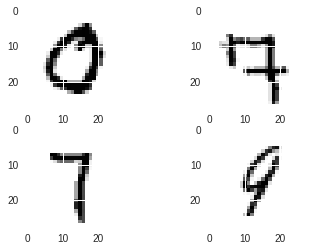

In [0]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[13][:,:,0])

plt.subplot(222)
plt.imshow(X_train[690][:,:,0])

plt.subplot(223)
plt.imshow(X_train[2375][:,:,0])

plt.subplot(224)
plt.imshow(X_train[41000][:,:,0])
plt.show()

In [0]:
img_shape = (28, 28, 1)    # for MNIST
batch_size = 16
latent_dim = 32  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(latent_dim, activation='relu')(x)



# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

encoder = Model(input_img, x)

In [0]:

# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim), mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])



In [0]:
# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

x = layers.Reshape(shape_before_flattening[1:])(x)

x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [0]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [0]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None, metrics = ['accuracy'])
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [0]:
vae.fit(x=X_train, y=None, shuffle=True, epochs=5, batch_size=batch_size)

Epoch 1/5
42000/42000 [==============================] - 37s 892us/step - loss: 0.1446
Epoch 2/5
42000/42000 [==============================] - 37s 871us/step - loss: 0.1032
Epoch 3/5
42000/42000 [==============================] - 37s 871us/step - loss: 0.0981
Epoch 4/5
42000/42000 [==============================] - 36s 860us/step - loss: 0.0956
Epoch 5/5
42000/42000 [==============================] - 36s 851us/step - loss: 0.0940


**Loss goes to 0.0983 with 4 CNN and 3 Dense Layers that form the encoder and decoder. The accuracy increases significantly with the addition of more Conv layers to the architecture.
**



```
**PART 2**
```



In [0]:
encoded_img = encoder.predict(X1_train) # Input to the next layer

encoded_test= encoder.predict(X1_test)

In [0]:
print(X1_train.shape)
print(array(encoded_img).shape)

print(y1_train.shape)

(12060, 28, 28, 1)
(12060, 32)
(12060, 10)


In [0]:
Out_img = keras.Input((latent_dim,))
#Out = layers.Dense(64, activation='softmax')(Out_img)
Out = layers.Dense(10, activation='softmax')(Out_img)

Part2 = Model(Out_img, Out)
Part2.summary()
Part2.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics = ['accuracy'])
Part2.fit(x=encoded_img, y=y1_train, batch_size= 64, epochs = 50)#, validation_data=(X1_test, y1_test))

In [0]:
scores = Part2.evaluate(encoded_test, y1_test, verbose=0)
print(scores)

[0.24464846319622463, 0.9314814814012059]


**2) Accuracy goes to 94% Testing in part 2 with One Input Layer, one hidden layer and one Output Layer
 The model gives around the same accuracy, 93% with just one input and one output layer.**

In [0]:

model2 = Sequential()

model2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))

model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))


# model2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu'))
# model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model2.add(Dropout(0.25))


model2.add(Flatten())
model2.add(Dense(256, activation = "relu"))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation = "softmax"))

In [0]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model2.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
model2.summary()
model2.fit(x=X_train, y=y_train, batch_size= 64, epochs = 10)#, validation_data=(X1_test, y1_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               1605888   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                2570      
Total para

In [0]:
print(X_train.shape)
print(X1_test.shape)
print(y_train.shape)
print(y1_test.shape)

(42000, 28, 28, 1)
(5940, 28, 28, 1)
(42000, 10)
(5940, 10)


In [0]:
scores = model2.evaluate(X1_test, y1_test, verbose=0)
print(scores)

[0.05488636649267823, 0.9855218855218856]


**3) Changing the parameters for the CNN in Part 3 doesn't show much difference in the testing and training accuracy. The problem and the dataset are such that a neural network can easily model itself into a almost perfect predictor. The accuracy ranges from around 97 to 99, depending on the number of layers with more layers giving better results.**

**4) The VAE model with the added Dense Layer gives us a testing accuracy of 94% while the simple CNN model gives us 98%. Although the loss in the VAE stands significantly higher at 22%, compared to the CNN loss of 5%. I believe that a simple CNN model should be preferred to a VAE in a case like this because it is a simple image classification problem without much complexity in features. The entire point of encoding images into lower dimensions and then expanding them is to learn to retain important features. However with simple digits, this in my opinion is needlessly complicating the task.
I found that using more number of CNN in the encoder and decoder is useful and we are working with images and they are good at modeling the latent representation.**